<a href="https://colab.research.google.com/github/Snizhana-DA/Sales-Analytics-Project/blob/main/Portfolio_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
# Завантаження необхідних бібліотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.ticker as mticker
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import normaltest, shapiro
from scipy.stats import kendalltau
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from scipy.stats import kruskal

In [100]:
# Створення датасету
from google.colab import auth
from google.cloud import bigquery
auth.authenticate_user()
project_id = "data-analytics-mate"
client = bigquery.Client(project=project_id)
query = """
SELECT
  s.date,
  s.ga_session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.name AS traffic_source,
  sp.channel,
  ac.id AS user_id,
  ac.is_verified,
  ac.is_unsubscribed,
  p.category,
  p.name AS product_name,
  p.price,
  p.short_description
FROM
  `DA.session` s
LEFT JOIN
  `data-analytics-mate.DA.order` o
ON
  o.ga_session_id = s.ga_session_id
LEFT JOIN
  `data-analytics-mate.DA.product` p
ON
  o.item_id = p.item_id
LEFT JOIN
  `data-analytics-mate.DA.session_params` sp
ON
  s.ga_session_id = sp.ga_session_id
LEFT JOIN
  `DA.account_session` acs
ON
  s.ga_session_id = acs.ga_session_id
LEFT JOIN
  `DA.account` ac
ON
  ac.id = acs.account_id

"""
query_job = client.query(query)
df = query_job.to_dataframe()
df.head()

,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,traffic_source,channel,user_id,is_verified,is_unsubscribed,category,product_name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,(organic),Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(direct),Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(direct),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(direct),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


# Опис датасету

In [101]:
# Виведення інформації про датасет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   traffic_source     349545 non-null  object 
 10  channel            349545 non-null  object 
 11  user_id            27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  product_name       33538 non-null   object 
 16  pr

In [102]:
# Підрахунок кількості унікальних сесій
print(f"Кількість унікальних сесій: {df['ga_session_id'].nunique()}")

Кількість унікальних сесій: 349545


In [103]:
# Визначення періоду часу
start_date = df["date"].min()
finish_date = df["date"].max()
print(f"Початковий період: {start_date}")
print(f"Кінцевий період: {finish_date}")

Початковий період: 2020-11-01
Кінцевий період: 2021-01-31


In [104]:
# Підрахунок кількості пропущених значень в датасеті
print(df.isna().sum())

date                      0
ga_session_id             0
continent                 0
country                   0
device                    0
browser                   0
mobile_model_name         0
operating_system          0
language             114266
traffic_source            0
channel                   0
user_id              321600
is_verified          321600
is_unsubscribed      321600
category             316007
product_name         316007
price                316007
short_description    316007
dtype: int64


In [105]:
# Перевірка датасету на наявність дублікатів
duplicate_rows = df.duplicated()
print(duplicate_rows.sum())

0


**Висновок:**

*Загальна кількість колонок*: Датасет містить 18 колонок.

*Кількість колонок числового типу*: У датасеті 5 числових колонок:
- ga_session_id (Int64)
- user_id (Int64)
- is_verified (Int64)
- is_unsubscribed (Int64)
- price (float64)

*Кількість колонок категоріального типу*: У датасеті 12 категоріальних колонок:
- continent (object)
- country (object)
- device (object)
- browser (object)
- mobile_model_name (object)
- operating_system (object)
- language (object)
- traffic_source (object)
- channel (object)
- category (object)
- product_name (object)
- short_description (object)

*Кількість колонок типу datetime*: Є 1 колонка типу datetime: date (dbdate)

*Кількість унікальних сесій*: Оскільки ga_session_id є унікальним і не містить пропущених значень, то загальна кількість сесій 349545.

*Період часу (від… до…)*: Від 2020-11-01 до 2021-01-31.

*Чи є пропущені значення?*: Так, є пропущені значення у 8 колонках.

*Колонки з найбільшою кількістю пропущених значень та можливі причини*:

- Найбільше пропущених значень у колонках, пов’язаних із замовленнями (category, product_name, price, short_description), оскільки не всі сесії містять покупки.
- user_id, is_verified, is_unsubscribed мають багато null, оскільки тільки частина користувачів зареєстрована.
- language має пропуски, бо не всі браузери передають цю інформацію.



# Підготовка даних для аналізу

In [106]:
# Заміна всіх пропущених категоріальних значень на "Unknown"
df[["language", "category", "product_name", "short_description"]] = df[["language", "category", "product_name", "short_description"]].fillna("Unknown")
# Заміна всіх пропущених числових  значень на 0
df[["user_id", "is_verified", "is_unsubscribed", "price"]] = df[["user_id", "is_verified", "is_unsubscribed", "price"]].fillna(0)
# Перевірка заміни пропущених значень в датасеті
print(df.isna().sum())

date                 0
ga_session_id        0
continent            0
country              0
device               0
browser              0
mobile_model_name    0
operating_system     0
language             0
traffic_source       0
channel              0
user_id              0
is_verified          0
is_unsubscribed      0
category             0
product_name         0
price                0
short_description    0
dtype: int64


In [107]:
# Переведення стовпця "date" в формат "datetime"
df["date"] = pd.to_datetime(df["date"])
# Перевірка зміни формату
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               349545 non-null  datetime64[ns]
 1   ga_session_id      349545 non-null  Int64         
 2   continent          349545 non-null  object        
 3   country            349545 non-null  object        
 4   device             349545 non-null  object        
 5   browser            349545 non-null  object        
 6   mobile_model_name  349545 non-null  object        
 7   operating_system   349545 non-null  object        
 8   language           349545 non-null  object        
 9   traffic_source     349545 non-null  object        
 10  channel            349545 non-null  object        
 11  user_id            349545 non-null  Int64         
 12  is_verified        349545 non-null  Int64         
 13  is_unsubscribed    349545 non-null  Int64   

# Аналітика продажів та клієнтської поведінки

In [108]:
# Визначення кількості сесій, де були замовлення
session_with_order = df[df["category"] != "Unknown"]["ga_session_id"].nunique()
print(f"Кількість унікальних сесій з замовленнями: {session_with_order}")


Кількість унікальних сесій з замовленнями: 33538


In [109]:
# Визначення Топ 3 континентів за кількістю замовлень
df_with_orders = df[df["category"] != "Unknown"]
grouped_by_continent = df_with_orders.groupby("continent")["ga_session_id"].count().reset_index()
top_3_continent = grouped_by_continent.sort_values(by="ga_session_id", ascending=False).head(3)
print(top_3_continent)

  continent  ga_session_id
2  Americas          18553
3      Asia           7950
4    Europe           6261


In [110]:
# Визначення Топ 5 країн за кількістю замовлень
grouped_by_country = df_with_orders.groupby("country")["ga_session_id"].count().reset_index()
top_5_country = grouped_by_country.sort_values(by="ga_session_id", ascending=False).head(5)
print(top_5_country)

            country  ga_session_id
104   United States          14673
43            India           3029
18           Canada           2560
103  United Kingdom           1029
33           France            678


In [111]:
# Визначення Топ 10 категорій за загальною сумою продажів
grouped_by_category = df.groupby("category")["price"].sum().reset_index()
top_10_category = grouped_by_category.sort_values(by="price", ascending=False).head(10)
print(top_10_category)

                            category      price
12                 Sofas & armchairs  8388254.5
5                             Chairs  6147748.8
1                               Beds  4919725.0
2         Bookcases & shelving units  3640818.1
3               Cabinets & cupboards  2336499.5
9                  Outdoor furniture  2142222.2
13                    Tables & desks  1790307.5
6   Chests of drawers & drawer units   906562.5
0                      Bar furniture   735503.0
7               Children's furniture   467697.0


In [112]:
# Визначення Топ 10 категорій у країні з найбільшими продажами
# Визначення країни з найбільшими продажами
grouped_by_country = df.groupby("country")["price"].sum().reset_index()
top_country = grouped_by_country.sort_values(by="price", ascending=False).iloc[0]["country"]
print(f"Top country: {top_country}")
# Фільтрування даних для цієї країни
df_top_country = df[df["country"] == top_country]
# Визначення топ-10 категорій у цій країні
grouped_by_category_top_country = df_top_country.groupby("category")["price"].sum().reset_index()
top_10_category_top_country = grouped_by_category_top_country.sort_values(by="price", ascending=False).head(10)
print(top_10_category_top_country)

Top country: United States
                            category      price
12                 Sofas & armchairs  3707144.5
5                             Chairs  2619773.8
1                               Beds  2213058.0
2         Bookcases & shelving units  1567606.9
3               Cabinets & cupboards   994545.5
9                  Outdoor furniture   929245.2
13                    Tables & desks   777865.0
6   Chests of drawers & drawer units   382388.0
0                      Bar furniture   330805.0
7               Children's furniture   207575.0


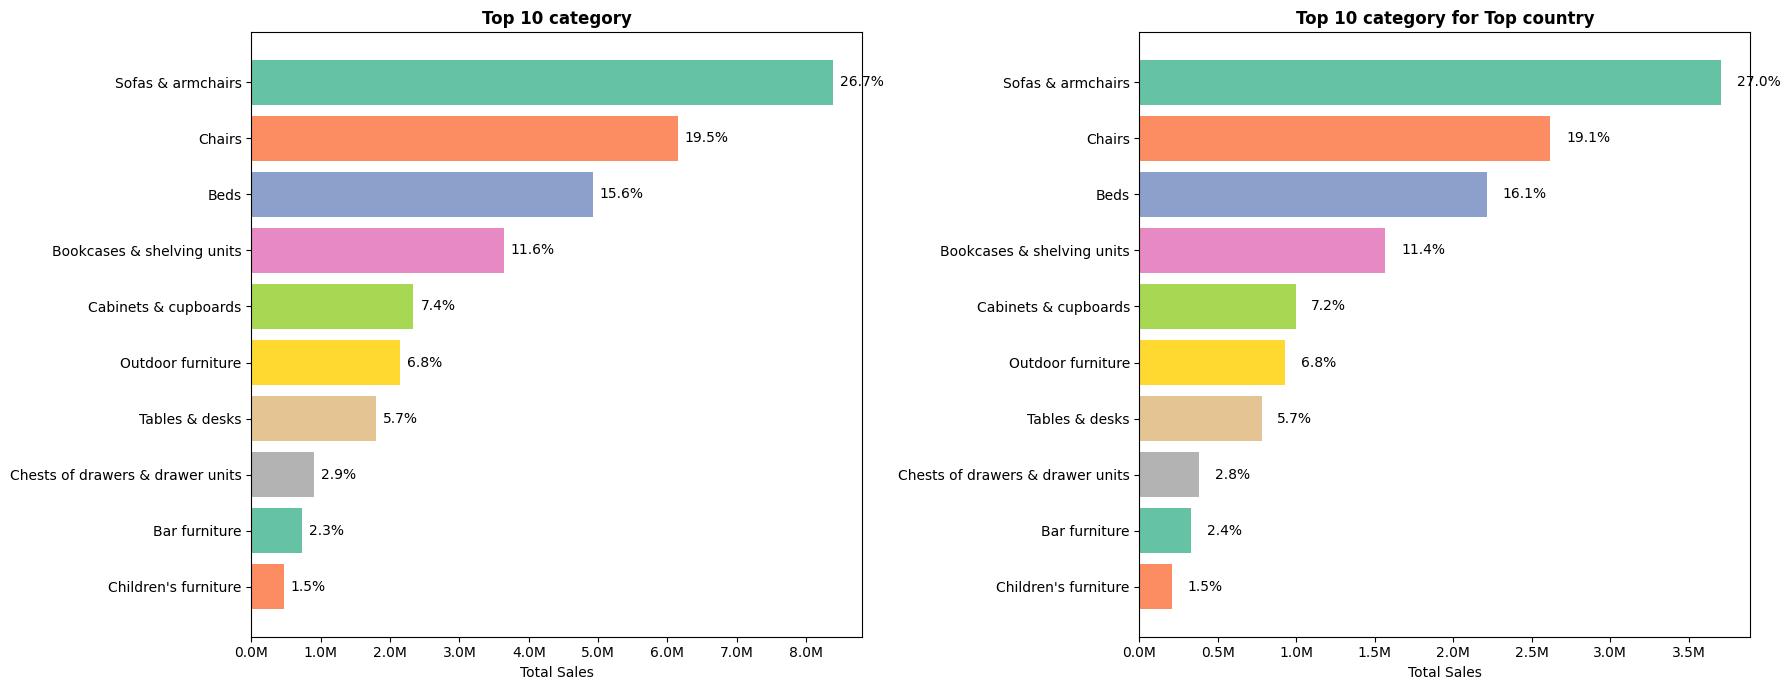

In [113]:
# Функція для побудови одного бар-чарту
def plot_bar_chart(ax, data, title):
    total_sales = data['price'].sum()
    data['percentage'] = (data['price'] / total_sales) * 100  # Розрахунок %
    bars = ax.barh(data['category'], data['price'], color=plt.cm.Set2.colors)
    ax.set_title(title, fontweight="bold")
    ax.set_xlabel("Total Sales")
    ax.invert_yaxis()  # Найбільші значення зверху
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))  # Формат M
    # Додаємо підписи у відсотках
    for bar, pct in zip(bars, data['percentage']):
        ax.text(bar.get_width() + 1e5, bar.get_y() + bar.get_height()/2, f"{pct:.1f}%", va='center')
# Створюємо графік з двома підграфіками
fig, ax = plt.subplots(1, 2, figsize=(18, 7))
plot_bar_chart(ax[0], top_10_category, "Top 10 category")
plot_bar_chart(ax[1], top_10_category_top_country, "Top 10 category for Top country")
plt.tight_layout()
plt.show()

**Висновок:** За результатами розрахунків топ-10 категорій товарів за загальною сумою продажів і для країни з найбільшими продажами (United States) виявлено, що список, категорій залишається незмінним. Візуальне порівняння на діаграмах показало мінімальні відмінності у відсотковому розподілі, що свідчить про схожі тенденції продажів як загалом, так і в цій країні.

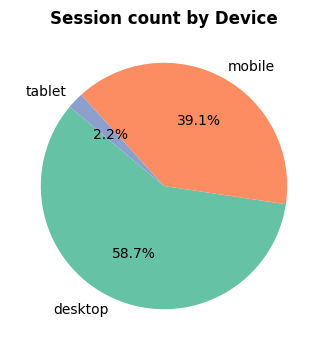

In [114]:
# Аналіз продажів у розрізі типів девайсів
grouped_by_device = df_with_orders.groupby("device")["ga_session_id"].count().reset_index()
# Створення кругової діаграми відображення % від загальних продажів
plt.figure(figsize=(4, 4))
plt.pie(grouped_by_device['ga_session_id'],         # Значення для секторів
    labels=grouped_by_device['device'],          # Підписи для секторів
    autopct='%1.1f%%',              # Відображення відсотків
    startangle=140,                 # Початковий кут для першого сектора
    colors=plt.cm.Set2.colors)     # Задаємо кольори
plt.title("Session count by Device", fontweight = "bold")
plt.show()


In [115]:
# Аналіз продажів у розрізі моделей девайсів
grouped_by_mobile_model_name = df_with_orders.groupby("mobile_model_name")["ga_session_id"].count().reset_index()
# Обчислюємо відсоток кожної моделі від загальної кількості
total_sessions = grouped_by_mobile_model_name["ga_session_id"].sum()
grouped_by_mobile_model_name["percentage"] = (grouped_by_mobile_model_name["ga_session_id"] / total_sessions) * 100
print(grouped_by_mobile_model_name)

  mobile_model_name  ga_session_id  percentage
0           <Other>           6801    20.27849
1            Chrome           9359   27.905659
2        ChromeBook           1877    5.596637
3              Edge            741    2.209434
4           Firefox            430    1.282128
5           Pixel 3            105    0.313078
6        Pixel 4 XL            117    0.348858
7            Safari           6833   20.373904
8              iPad            456    1.359652
9            iPhone           6819   20.332161


In [116]:
# Аналіз продажів за джерелами трафіку
grouped_by_traffic_source = df_with_orders.groupby("traffic_source")["ga_session_id"].count().reset_index()
# Обчислюємо відсоток кожного джерела трафіку від загальної кількості
total_sessions = grouped_by_traffic_source["ga_session_id"].sum()
grouped_by_traffic_source["percentage"] = (grouped_by_traffic_source["ga_session_id"] / total_sessions) * 100
print(grouped_by_traffic_source)

   traffic_source  ga_session_id  percentage
0  (data deleted)           2055    6.127378
1        (direct)           7800   23.257201
2       (organic)          11430   34.080744
3      (referral)           6001   17.893136
4         <Other>           6252   18.641541


In [117]:
# Аналіз суми продажів за операційними системами
grouped_by_operating_system = df.groupby("operating_system")["price"].sum().reset_index()
print(grouped_by_operating_system)

  operating_system       price
0          <Other>    822555.8
1          Android   2789985.1
2        Macintosh   2504967.3
3              Web  18445904.5
4          Windows   3804989.0
5              iOS   3603329.4


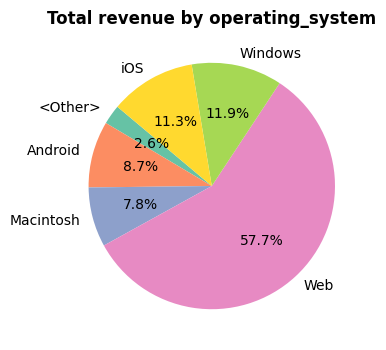

In [118]:
# Створення кругової діаграми відображення % від загальних продажів
plt.figure(figsize=(4, 4))
plt.pie(grouped_by_operating_system['price'],         # Значення для секторів
    labels=grouped_by_operating_system['operating_system'],          # Підписи для секторів
    autopct='%1.1f%%',              # Відображення відсотків
    startangle=140,                 # Початковий кут для першого сектора
    colors=plt.cm.Set2.colors)     # Задаємо кольори
plt.title("Total revenue by operating_system", fontweight = "bold")
plt.show()

In [119]:
# Визначення відсотоку зареєстрованих користувачів, що підтвердили електронну адресу
total_users = df[df["user_id"] != 0]["user_id"].count()  # Рахуємо кількість аккаунтів, враховуючи, що пропущені значення були змінені на 0
verified_users = df["is_verified"].sum()
verified_users_percentage = verified_users / total_users * 100
print(f"Відсоток зареєстрованих користувачів, що підтвердили електронну адресу: {verified_users_percentage:.2f}%")

Відсоток зареєстрованих користувачів, що підтвердили електронну адресу: 71.70%


In [120]:
# Визначення відсотоку зареєстрованих користувачів, що відписались від розсилки
total_users = df[df["user_id"] != 0]["user_id"].count()
unsubscribed_users = df["is_unsubscribed"].sum()
unsubscribed_users_percentage = unsubscribed_users / total_users * 100
print(f"Відсоток зареєстрованих користувачів, що відписались від розсилки: {unsubscribed_users_percentage:.2f}%")

Відсоток зареєстрованих користувачів, що відписались від розсилки: 16.94%


In [121]:
# Аналіз поведінки користувачів в плані продажів
total_users_cnt = df[df["user_id"] != 0]["user_id"].count()
unsubscribed_users_cnt = df["is_unsubscribed"].sum()
subscribed_users_cnt = total_users_cnt - unsubscribed_users_cnt
# Визначення кількості замовлень для підписаних і відписаних користувачів
order_cnt_for_total_users = df[(df["category"] != "Unknown") & (df["user_id"] != 0)]["ga_session_id"].count()
order_cnt_for_unsubscribed_users = df[(df["category"] != "Unknown") & (df["is_unsubscribed"] == 1)]["ga_session_id"].count()
order_cnt_for_subscribed_users = order_cnt_for_total_users - order_cnt_for_unsubscribed_users
# Визначення відсотку користувачів, які зробили замовлення серед підписаних і відписаних користувачів
unsubscribed_users_order_percentage = order_cnt_for_unsubscribed_users  / unsubscribed_users_cnt * 100
subscribed_users_order_percentage = order_cnt_for_subscribed_users  / subscribed_users_cnt * 100
# Виведення результатів
print(f"Кількість користувачів, що відписались від розсилки: {unsubscribed_users_cnt}")
print(f"Кількість замовлень користувачами, що відписались від розсилки: {order_cnt_for_unsubscribed_users}")
print(f"Відсоток користувачів, які зробили замовлення серед тих, хто відписався від розсилки: {unsubscribed_users_order_percentage:.2f}%")
print("-"*90)  # Роздільник для кращої читабельності
print(f"Кількість користувачів, що залишили підписку: {subscribed_users_cnt}")
print(f"Кількість замовлень користувачами, що залишили підписку: {order_cnt_for_subscribed_users}")
print(f"Відсоток користувачів, які зробили замовлення серед тих, хто залишив підписку: {subscribed_users_order_percentage:.2f}%")


Кількість користувачів, що відписались від розсилки: 4735
Кількість замовлень користувачами, що відписались від розсилки: 447
Відсоток користувачів, які зробили замовлення серед тих, хто відписався від розсилки: 9.44%
------------------------------------------------------------------------------------------
Кількість користувачів, що залишили підписку: 23210
Кількість замовлень користувачами, що залишили підписку: 2334
Відсоток користувачів, які зробили замовлення серед тих, хто залишив підписку: 10.06%


**Висновок:**
Аналіз показує, що користувачі, які досі підписані на розсилку, демонструють вищу активність у замовленнях. Відсоток замовлень серед відписаних користувачів складає 9,44%, тоді як підписані користувачі здійснюють замовлення з частотою 10,06%. Хоча різниця не є кардинальною, вона підтверджує, що email-розсилки мають позитивний ефект на продажі і підписка на розсилку може позитивно впливати на залученість і купівельну активність.


In [122]:
# Визначення країн з найбільшою кількістю зареєстрованих користувачів
df_with_accounts = df[df["user_id"] != 0]
grouped_by_country = df_with_accounts.groupby("country")["user_id"].count().reset_index()
top_10_country = grouped_by_country.sort_values(by="user_id", ascending=False).head(10)
print(top_10_country)

            country  user_id
104   United States    12384
43            India     2687
18           Canada     2067
103  United Kingdom      859
33           France      553
92            Spain      536
96           Taiwan      500
35          Germany      490
20            China      490
48            Italy      386


In [123]:
# Визначення кількості акаунтів за мовою браузера
# Залишаємо лише перші дві літери мови
df_with_accounts["language"] = df_with_accounts["language"].str[:2]
# Об'єднуємо всі варіанти англійської мови під "en"
df_with_accounts["language"] = df_with_accounts["language"].replace(["en"], "en")
# Видаляємо рядки, де значення "language" == "Unknown"
df_with_accounts = df_with_accounts[df_with_accounts["language"] != "Un"]
# Групуємо і підраховуємо
grouped_by_language = df_with_accounts.groupby("language")["user_id"].count().reset_index()
print(grouped_by_language)

  language  user_id
0       de      247
1       en    16418
2       es      442
3       fr      462
4       ko      217
5       zh      958


<ipython-input-123-413252d0c81b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_accounts["language"] = df_with_accounts["language"].str[:2]
<ipython-input-123-413252d0c81b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_accounts["language"] = df_with_accounts["language"].replace(["en"], "en")


# Аналіз динаміки продажів

In [124]:
# Аналіз продажів у часі
grouped_by_date = df_with_orders.groupby("date")["ga_session_id"].count().reset_index()
print(grouped_by_date)

         date  ga_session_id
0  2020-11-01            281
1  2020-11-02            368
2  2020-11-03            561
3  2020-11-04            370
4  2020-11-05            388
..        ...            ...
83 2021-01-23            313
84 2021-01-24            296
85 2021-01-25            370
86 2021-01-26            385
87 2021-01-27            299

[88 rows x 2 columns]


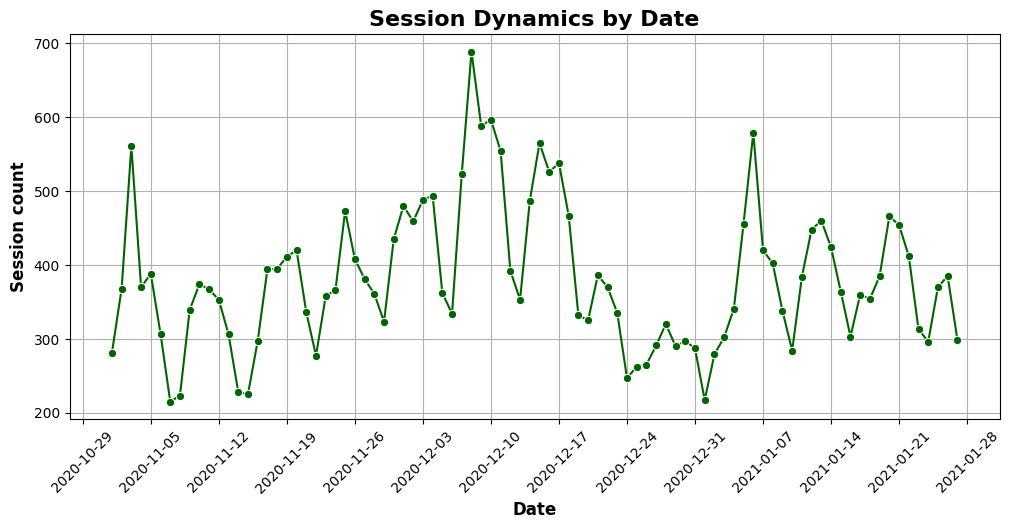

In [125]:
# Створення візуалізації динаміки продажів у часі
grouped_by_date = df_with_orders.groupby("date")["ga_session_id"].count().reset_index()
plt.figure(figsize=(12, 5))
sns.lineplot(data=grouped_by_date, x="date", y="ga_session_id", marker="o", color = "darkgreen")
plt.title("Session Dynamics by Date", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Session count", fontsize=12, fontweight="bold")
# Щільне відображення підписів дат
plt.xticks(rotation=45)  # Повертаємо дати
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Відображаємо кожні 7 днів
plt.grid()
plt.show()


**Висновок:** Динаміка продажів у розрізі дат показує зміну кількості сесій у часі. Спостерігається чітка сезонність:
- Є піки активності в грудні та на початку січня, що може бути пов’язано з передсвятковими покупками (Різдво, Новий рік).
- Після свят спостерігається зниження трафіку.
- Також можна помітити регулярні коливання, що можуть відповідати тижневим циклам (зниження у вихідні).


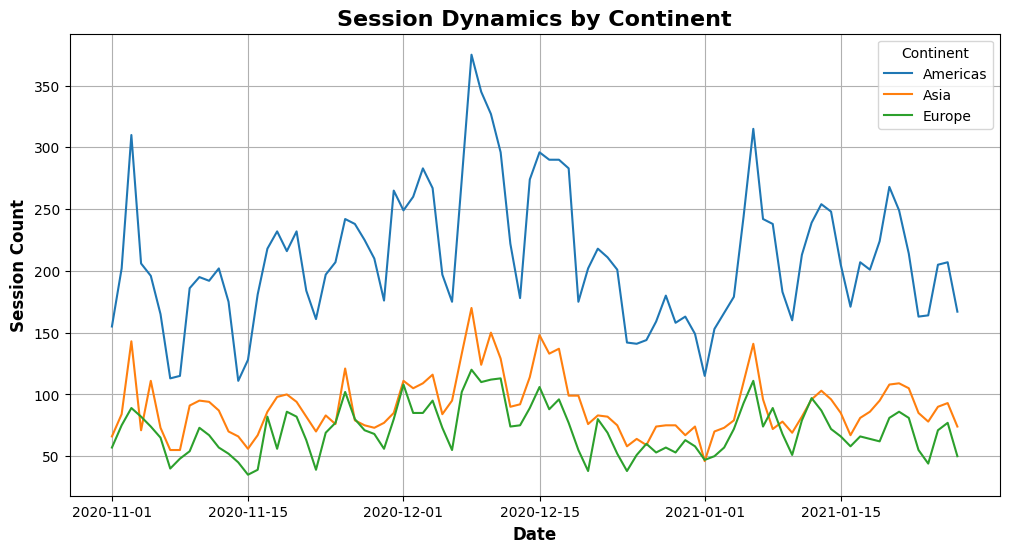

In [126]:
# Аналіз динаміки продажів в Америці, Азії та Європі
# Фільтрування даних для континентів
df_countinent = df_with_orders[df_with_orders["continent"].isin(["Americas", "Asia", "Europe"])]
# Групування відфільтрованих даних за датою та континентами
grouped_by_date_continent = df_countinent.groupby(["date", "continent"])["ga_session_id"].count().reset_index()
# Створення візуалізації
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_by_date_continent, x="date", y="ga_session_id", hue="continent")
plt.title("Session Dynamics by Continent", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Session Count", fontsize=12, fontweight="bold")
plt.legend(title="Continent")
plt.grid()
plt.show()

**Висновок:**

*Динаміка сесій у розрізі континентів*:

- Americas має найбільшу кількість сесій і демонструє найбільші коливання.
- Asia та Europe мають нижчий рівень активності, але їхні тренди теж корелюють із загальною сезонністю.
- В усіх регіонах можна помітити зростання активності у грудні та падіння після свят.

Загалом, дані свідчать, що Americas – найактивніший регіон, а Europe та Asia мають значно меншу активність.

In [127]:
# Аналіз динаміки продажів у розрізі каналів трафіку
grouped_by_channel = df_with_orders.groupby(["channel"])["ga_session_id"].count().reset_index()
print(grouped_by_channel)

          channel  ga_session_id
0          Direct           7800
1  Organic Search          11921
2     Paid Search           9042
3   Social Search           2716
4       Undefined           2059


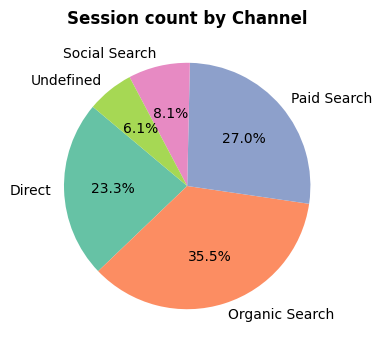

In [128]:
# Створення кругової діаграми відображення % від загальних продажів
plt.figure(figsize=(4, 4))
plt.pie(grouped_by_channel['ga_session_id'],         # Значення для секторів
    labels=grouped_by_channel['channel'],          # Підписи для секторів
    autopct='%1.1f%%',              # Відображення відсотків
    startangle=140,                 # Початковий кут для першого сектора
    colors=plt.cm.Set2.colors)     # Задаємо кольори
plt.title("Session count by Channel", fontweight = "bold")
plt.show()

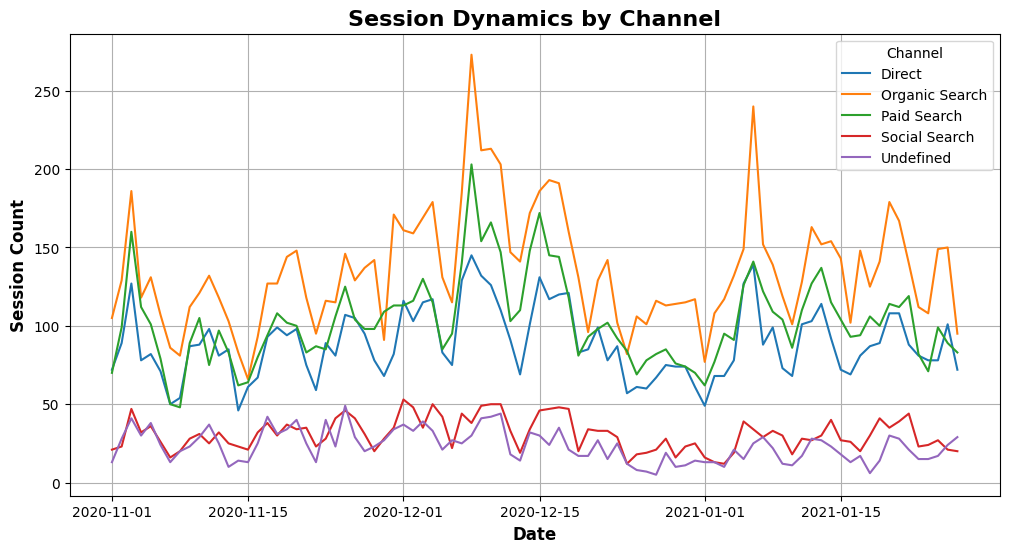

In [129]:
# Групування даних за датою та каналами
grouped_by_date_channel = df_with_orders.groupby(["date", "channel"])["ga_session_id"].count().reset_index()
# Створення візуалізації
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_by_date_channel, x="date", y="ga_session_id", hue="channel")
plt.title("Session Dynamics by Channel", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Session Count", fontsize=12, fontweight="bold")
plt.legend(title="Channel")
plt.grid()
plt.show()

**Висновок:**

*Динаміка сесій у розрізі каналів трафіку:*

- Organic Search та Paid Search – основні джерела трафіку, що демонструють значні піки в грудні та на початку січня.
-  Direct також впливає на зростання трафіку, особливо в періоди пікових продажів.
- Social Search та Undefined мають незначний вплив.

Загалом, дані свідчать, що Organic Search, Paid Search та Direct – головні джерела трафіку.

In [130]:
# Аналіз динаміки продажів у розрізі типів девайсів
grouped_by_device = df_with_orders.groupby(["device"])["ga_session_id"].count().reset_index()
print(grouped_by_device)

    device  ga_session_id
0  desktop          19702
1   mobile          13113
2   tablet            723


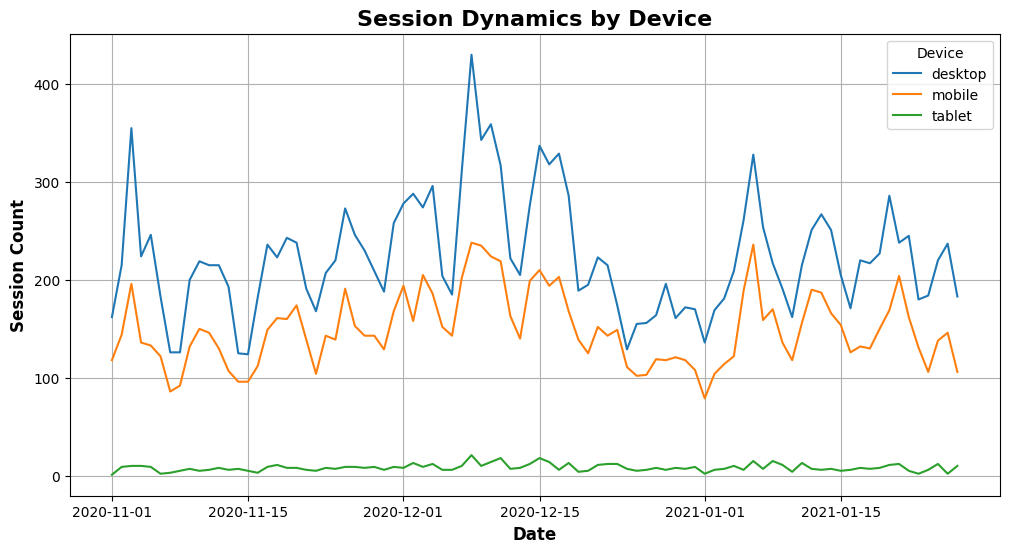

In [131]:
# Групування даних за датою та типами девайсів
grouped_by_date_device = df_with_orders.groupby(["date", "device"])["ga_session_id"].count().reset_index()
# Створення візуалізації
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_by_date_device, x="date", y="ga_session_id", hue="device")
plt.title("Session Dynamics by Device", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Session Count", fontsize=12, fontweight="bold")
plt.legend(title="Device")
plt.grid()
plt.show()

**Висновок:**

*Динаміка сесій у розрізі пристроїв:*

- Desktop залишається головним каналом доступу, з найбільшою кількістю сесій і вираженими піками активності.
-	Mobile має стабільний рівень, але деще менший за десктоп.
-	Tablet має найменший вплив.

Загалом, дані свідчать, десктоп та мобільні пристрої є основними пристроями для покупок.



# Зведені таблиці

In [132]:
# Створення зведеної таблиці, яка показує кількість сесій у розрізі каналів трафіку та типів девайсів
pivot_table = pd.pivot_table(df_with_orders, values=["ga_session_id"], index="channel", columns="device", aggfunc="count")
print(pivot_table)

               ga_session_id              
device               desktop mobile tablet
channel                                   
Direct                  4655   2985    160
Organic Search          7011   4655    255
Paid Search             5261   3574    207
Social Search           1594   1065     57
Undefined               1181    834     44


In [133]:
# Створення зведеної таблиці, яка показує загальні продажі за категоріями товарів (топ-10 категорій) у різних країнах (топ-5 країн)
# Tоп-10 категорій за загальним продажем
top_categories = df.groupby("category")["price"].sum().nlargest(10).index
# Tоп-5 країн за загальним продажем
top_countries = df.groupby("country")["price"].sum().nlargest(5).index
# Фільтруємо датафрейм за вибраними категоріями та країнами
filtered_df = df[df["category"].isin(top_categories) & df["country"].isin(top_countries)]
pivot_table = pd.pivot_table(filtered_df, values="price", index="category", columns="country", aggfunc="sum")
# Виводимо таблицю
print(pivot_table.to_string())

country                             Canada    France     India  United Kingdom  United States
category                                                                                     
Bar furniture                      51724.0   11199.0   57657.0         22103.0       330805.0
Beds                              354772.0  116414.0  358319.5        133816.0      2213058.0
Bookcases & shelving units        278981.9   73830.0  364507.4        113987.6      1567606.9
Cabinets & cupboards              181802.0   59101.5  191888.0         71684.5       994545.5
Chairs                            417740.8  134029.4  544309.2        188519.4      2619773.8
Chests of drawers & drawer units   71952.0   21544.5   73111.0         36784.0       382388.0
Children's furniture               30264.0   14258.0   39177.0         13348.0       207575.0
Outdoor furniture                 185322.8   40486.4  162289.4         57002.4       929245.2
Sofas & armchairs                 692427.5  187735.0  788430

In [134]:
# Створення зведеної таблиці, яка показує кількість сесій в розрізі браузерів та операційних систем
pivot_table = pd.pivot_table(df_with_orders, values=["ga_session_id"], index="browser", columns="operating_system", aggfunc="count")
print(pivot_table)

                 ga_session_id                                       
operating_system       <Other> Android Macintosh    Web Windows   iOS
browser                                                              
<Other>                      9     217         7    515      91    26
Android Webview           <NA>      99      <NA>    321    <NA>  <NA>
Chrome                     849    2526      1857  13993    3401   389
Edge                      <NA>    <NA>         6    480     266  <NA>
Firefox                     24      10        49    362     138  <NA>
Safari                    <NA>    <NA>       654   3866    <NA>  3383


In [135]:
# Створення зведеної таблиці, яка показує загальну суму продажів у розрізі континентів та моделей девайсів
pivot_table = pd.pivot_table(df, values=["price"], index="mobile_model_name", columns="continent", aggfunc="sum")
# Виводимо таблицю
print(pivot_table.to_string())

                      price                                                    
continent         (not set)   Africa   Americas       Asia     Europe   Oceania
mobile_model_name                                                              
<Other>             10469.0  75228.5  3630042.4  1642129.8  1117926.1   59535.0
Chrome              20597.4  62929.2  5044340.6  2018772.0  1653279.5   99605.2
ChromeBook           4411.0  24142.0  1021732.6   406340.9   351187.7   22644.5
Edge                 2902.0   9194.0   396370.5   148902.4   136382.4    3471.0
Firefox                25.0   4491.0   239354.6    98748.8    71687.5    6760.0
Pixel 3                 0.0      0.0    51989.7    29841.0    18533.5    8784.0
Pixel 4 XL              NaN      0.0    72669.5    28982.2    16636.0       0.0
Safari              22103.0  91037.0  3523966.8  1554347.5  1186219.8  113388.0
iPad                   70.0   2071.0   250383.7   100660.0    89689.5    5980.0
iPhone              13490.0  62138.3  34

# Статистичний аналіз взаємозв’язків

### Аналіз кількості сесій та загальних продажів за кожну дату

In [136]:
# Групуємо дані
grouped_data = df_with_orders.groupby("date").agg(
    session_count=("ga_session_id", "count"),  # Кількість сесій
    total_revenue=("price", "sum")            # Сума замовлень
).reset_index()
print(grouped_data)

         date  session_count  total_revenue
0  2020-11-01            281       244292.5
1  2020-11-02            368       355506.8
2  2020-11-03            561       498979.6
3  2020-11-04            370       339187.1
4  2020-11-05            388       391276.6
..        ...            ...            ...
83 2021-01-23            313       290605.5
84 2021-01-24            296       243818.4
85 2021-01-25            370       305089.3
86 2021-01-26            385       372057.3
87 2021-01-27            299       286340.7

[88 rows x 3 columns]


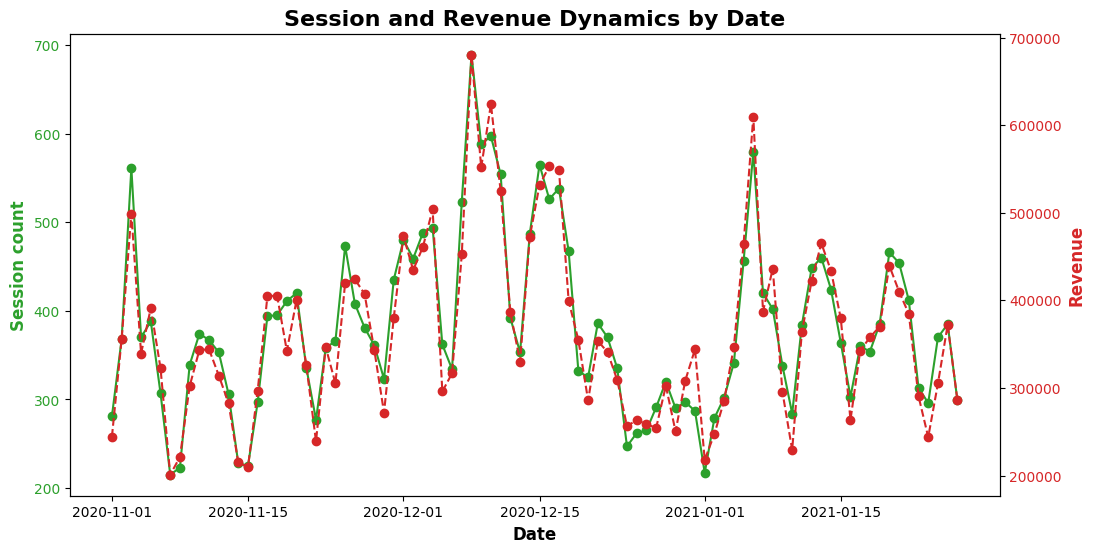

In [137]:
# Створення графіку, щоб побачити взаємозв’язок між метриками
fig, ax1 = plt.subplots(figsize=(12, 6))
# Перша шкала (кількість сесій)
ax1.set_xlabel("Date", fontsize=12, fontweight="bold")
ax1.set_ylabel("Session count", color="tab:green", fontsize=12, fontweight="bold")
ax1.plot(grouped_data["date"], grouped_data["session_count"], color="tab:green", marker="o", label="Кількість сесій")
ax1.tick_params(axis="y", labelcolor="tab:green")
# Друга шкала (сума замовлень)
ax2 = ax1.twinx()
ax2.set_ylabel("Revenue", color="tab:red", fontsize=12, fontweight="bold")
ax2.plot(grouped_data["date"], grouped_data["total_revenue"], color="tab:red", marker="o", linestyle="dashed", label="Сума замовлень")
ax2.tick_params(axis="y", labelcolor="tab:red")
plt.title("Session and Revenue Dynamics by Date", fontsize=16, fontweight="bold")
plt.show()


**Висновок:** На графіку видно, що кількість сесій та revenue  мають схожі тренди. Зростання та спади майже синхронні. У пікові дні кількість сесій та виручка зростають разом. У періоди спаду обидва показники зменшуються. Сильні піки та падіння збігаються. Є винятки - деякі точки не ідеально відповідають тренду, але загальна залежність є.





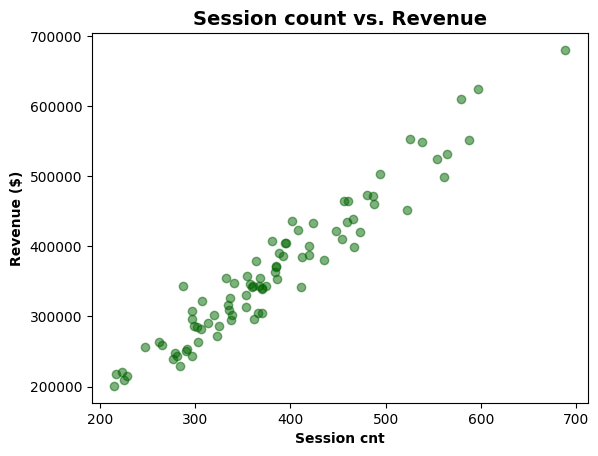

In [138]:
# Створення діаграми розсіювання, щоб проаналізувати зв'язок між кількістю сесій та розміром суми замовлень
plt.scatter(grouped_data['session_count'], grouped_data['total_revenue'], color="darkgreen", alpha=0.5)
plt.title("Session count vs. Revenue", fontsize=14, fontweight = "bold")  # Title of the graph
plt.xlabel("Session cnt", fontweight = "bold")  # X-axis label
plt.ylabel("Revenue ($)", fontweight = "bold")  # Y-axis label
plt.show()

**Висновок:** Графік показує чітку тенденцію: зі зростанням кількості сесій, загальна сума замовлень, стає більшою.

In [139]:
# Розрахунок коефіцієнту кореляції Пірсона між кількістю сесій та розміром суми замовлень
print(f"Test statistic and p-value: {pearsonr(grouped_data['session_count'], grouped_data['total_revenue'])}")
pearson_corr = grouped_data['session_count'].corr(grouped_data['total_revenue'])
print(f"Коефіцієнт кореляції Пірсона:: {pearson_corr}")

Test statistic and p-value: PearsonRResult(statistic=0.9642422533124871, pvalue=2.2447783149167257e-51)
Коефіцієнт кореляції Пірсона:: 0.9642422533124876


In [140]:
# Розрахунок коефіцієнту кореляції Спірмена між кількістю сесій та розміром суми замовлень
print(f"Test statistic and p-value: {spearmanr(grouped_data['session_count'], grouped_data['total_revenue'])}")
spearman_corr = grouped_data['session_count'].corr(grouped_data['total_revenue'], method='spearman')
print(f"Коефіцієнт кореляції Спірмена: {spearman_corr}")

Test statistic and p-value: SignificanceResult(statistic=0.950959845605782, pvalue=1.346332900826623e-45)
Коефіцієнт кореляції Спірмена: 0.950959845605782


**Висновок:**
В результаті виконання обох статистичних методів, ми отримали високі значення коефіцієнта кореляції приблизно 0.96, тому робимо висновок, що змінні мають сильну пряму кореляцію. Оскільки p-value < 0.05, взаємозв'язок між кількістю сесій та розміром суми замовлень є статистично значущим.

### Визначення кореляції між продажами на різних континентах

In [141]:
# Групування даних по континентах і підрахунок загальних продажів
grouped_continent = df.groupby("continent")["price"].sum().reset_index()
# Визначення Топ-3 континентів за загальною сумою продажів
continent_top_3 = grouped_continent.sort_values(by="price", ascending=False).head(3)
# Тепер потрібно взяти всі дані по цим континентам і створити таблицю розподілу продажів
df_top_3 = df[df["continent"].isin(continent_top_3["continent"])]
# Побудова зведеної таблиці: рядки – дати, стовпці – континенти, значення – сума продажів
pivot_table = df_top_3.pivot_table(index="date", columns="continent", values="price", aggfunc="sum")
# Кореляція Пірсона
pearson_corr = pivot_table.corr(method="pearson")
# Кореляція Спірмена
spearman_corr = pivot_table.corr(method="spearman")
# Розрахунок p-value
pearson_pvalues = pivot_table.corr(method=lambda x, y: stats.pearsonr(x, y)[1])
spearman_pvalues = pivot_table.corr(method=lambda x, y: stats.spearmanr(x, y)[1])
print("Кореляція Пірсона:\n", pearson_corr)
print("-"*50)  # Роздільник для кращої читабельності
print("\nP-value для кореляції Пірсона:\n", pearson_pvalues)
print("-"*50)  # Роздільник для кращої читабельності
print("Кореляція Спірмена:\n", spearman_corr)
print("-"*50)  # Роздільник для кращої читабельності
print("\nP-value для кореляції Спірмена:\n", spearman_pvalues)

Кореляція Пірсона:
 continent  Americas      Asia    Europe
continent                              
Americas   1.000000  0.792025  0.770586
Asia       0.792025  1.000000  0.768427
Europe     0.770586  0.768427  1.000000
--------------------------------------------------

P-value для кореляції Пірсона:
 continent      Americas          Asia        Europe
continent                                          
Americas   1.000000e+00  5.409189e-21  2.671449e-19
Asia       5.409189e-21  1.000000e+00  3.864946e-19
Europe     2.671449e-19  3.864946e-19  1.000000e+00
--------------------------------------------------
Кореляція Спірмена:
 continent  Americas      Asia   Europe
continent                             
Americas   1.000000  0.709902  0.67257
Asia       0.709902  1.000000  0.65711
Europe     0.672570  0.657110  1.00000
--------------------------------------------------

P-value для кореляції Спірмена:
 continent      Americas          Asia        Europe
continent                       

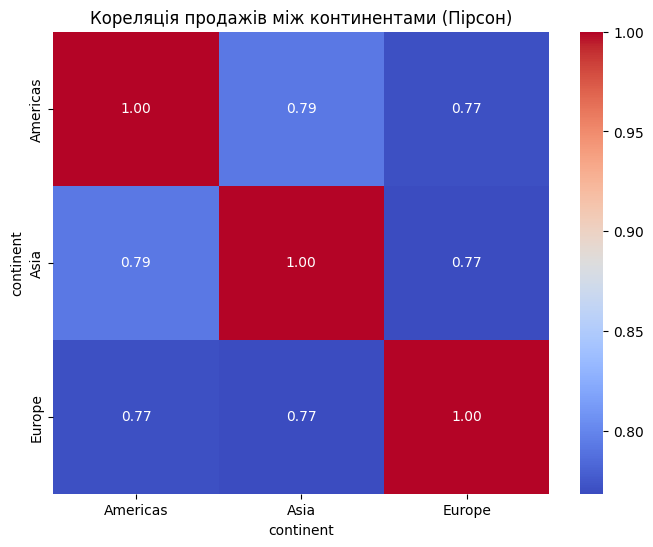

In [142]:
# Візуалізація кореляцій heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Кореляція продажів між континентами (Пірсон)")
plt.show()

**Висновок щодо кореляції продажів між континентами:** Усі три континенти мають сильну позитивну кореляцію між продажами, а низькі p-value вказують на статистичну значущість цих взаємозв’язків.

- *Кореляція між Америкою та Азією*

Пірсон: 0.79, Спірмен: 0.71. Висока позитивна кореляція, що вказує на подібні тренди продажів у цих регіонах. p-value ≈ 5.4e-21, що свідчить про статистичну значущість кореляції.
- *Кореляція між Америкою та Європою*

Пірсон: 0.77, Спірмен: 0.67. Сильна позитивна кореляція, продажі в Америці та Європі змінюються схожим чином. p-value ≈ 2.67e-19, тобто кореляція статистично значуща.

- *Кореляція між Азією та Європою*

Пірсон: 0.77, Спірмен: 0.66. Висока позитивна кореляція, що показує подібні тенденції між цими двома ринками.	p-value ≈ 3.86e-19, що підтверджує значущість кореляції.

### Визначення кореляції між продажами за різними каналами трафіку

In [143]:
# Побудова зведеної таблиці: рядки – дати, стовпці – канали, значення – сума продажів
pivot_table = df.pivot_table(index="date", columns="channel", values="price", aggfunc="sum")
# Кореляція Пірсона
pearson_corr = pivot_table.corr(method="pearson")
# Кореляція Спірмена
spearman_corr = pivot_table.corr(method="spearman")
# Розрахунок p-value для всіх пар змінних
pearson_pvalues = pivot_table.corrwith(pivot_table, method=lambda x, y: stats.pearsonr(x, y)[1])
spearman_pvalues = pivot_table.corrwith(pivot_table, method=lambda x, y: stats.spearmanr(x, y)[1])
# Розрахунок p-value
pearson_pvalues = pivot_table.corr(method=lambda x, y: stats.pearsonr(x, y)[1])
spearman_pvalues = pivot_table.corr(method=lambda x, y: stats.spearmanr(x, y)[1])
print("Кореляція Пірсона:\n", pearson_corr)
print("-"*90)  # Роздільник для кращої читабельності
print("\nP-value для кореляції Пірсона:\n", pearson_pvalues)
print("-"*90)  # Роздільник для кращої читабельності
print("Кореляція Спірмена:\n", spearman_corr)
print("-"*90)  # Роздільник для кращої читабельності
print("\nP-value для кореляції Спірмена:\n", spearman_pvalues)

Кореляція Пірсона:
 channel           Direct  Organic Search  Paid Search  Social Search  Undefined
channel                                                                        
Direct          1.000000        0.837833     0.814072       0.604060   0.517505
Organic Search  0.837833        1.000000     0.870086       0.583117   0.526068
Paid Search     0.814072        0.870086     1.000000       0.596428   0.521961
Social Search   0.604060        0.583117     0.596428       1.000000   0.455126
Undefined       0.517505        0.526068     0.521961       0.455126   1.000000
------------------------------------------------------------------------------------------

P-value для кореляції Пірсона:
 channel               Direct  Organic Search   Paid Search  Social Search     Undefined
channel                                                                                
Direct          1.000000e+00    2.190420e-25  5.896435e-23   1.831889e-10  1.275436e-07
Organic Search  2.190420e-25    

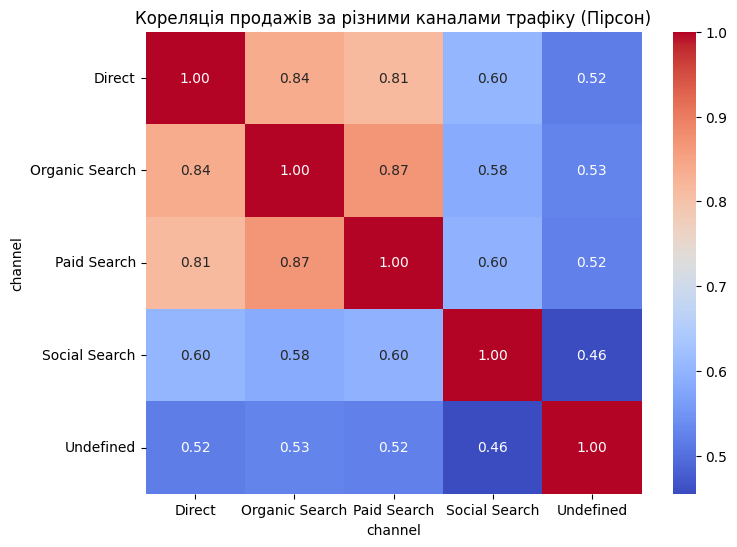

In [144]:
# Візуалізація кореляцій heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Кореляція продажів за різними каналами трафіку (Пірсон)")
plt.show()

**Висновок щодо кореляції продажів за різними каналами трафіку:** Продажі між Direct, Organic Search та Paid Search мають сильну позитивну кореляцію, що може свідчити про схожі поведінку користувачів у цих каналах. Social Search та Undefined мають слабшу кореляцію з іншими каналами, що вказує на їхню відносну незалежність.

*Кореляція Пірсона*
- Найвища кореляція спостерігається між Organic Search та Paid Search (0.87), а також між Direct та Organic Search (0.84). Це свідчить про сильний взаємозв’язок між органічним та платним пошуком.
- Direct та Paid Search (0.81) також мають високу кореляцію, що може вказувати на перетин користувачів між цими каналами.
- Social Search та Undefined (0.46) мають найнижчу кореляцію серед усіх пар, що свідчить про слабший взаємозв’язок між цими каналами.

*Кореляція Спірмена*
- Значення дещо нижчі, але тренди зберігаються. Organic Search та Paid Search (0.79), а також Direct та Organic Search (0.78) знову демонструють найсильніший взаємозв’язок.
- Social Search має слабкіші зв’язки з іншими каналами (наприклад, 0.47 з Direct, 0.46 з Organic Search).

*Статистична значущість*
Всі p-value дуже малі, що означає статистично значущу кореляцію між каналами.

### Визначення кореляції між продажами для різних категорій

In [145]:
# Групування даних по категоріям і підрахунок загальних продажів
grouped_category = df.groupby("category")["price"].sum().reset_index()
# Визначення Топ-5 категорій за загальною сумою продажів
category_top_5 = grouped_category.sort_values(by="price", ascending=False).head(5)
# Тепер потрібно взяти всі дані по цим категоріям і створити таблицю розподілу продажів
df_top_5 = df[df["category"].isin(category_top_5["category"])]
# Побудова зведеної таблиці: рядки – дати, стовпці – категорії, значення – сума продажів
pivot_table = df_top_5.pivot_table(index="date", columns="category", values="price", aggfunc="sum")
# Кореляція Пірсона
pearson_corr = pivot_table.corr(method="pearson")
# Кореляція Спірмена
spearman_corr = pivot_table.corr(method="spearman")
# Розрахунок p-value
pearson_pvalues = pivot_table.corr(method=lambda x, y: stats.pearsonr(x, y)[1])
spearman_pvalues = pivot_table.corr(method=lambda x, y: stats.spearmanr(x, y)[1])
print("Кореляція Пірсона:\n", pearson_corr)
print("-"*120)  # Роздільник для кращої читабельності
print("\nP-value для кореляції Пірсона:\n", pearson_pvalues)
print("-"*120)  # Роздільник для кращої читабельності
print("Кореляція Спірмена:\n", spearman_corr)
print("-"*120)  # Роздільник для кращої читабельності
print("\nP-value для кореляції Спірмена:\n", spearman_pvalues)

Кореляція Пірсона:
 category                        Beds  Bookcases & shelving units  Cabinets & cupboards    Chairs  Sofas & armchairs
category                                                                                                           
Beds                        1.000000                    0.592913              0.514609  0.554500           0.535378
Bookcases & shelving units  0.592913                    1.000000              0.539428  0.637090           0.666194
Cabinets & cupboards        0.514609                    0.539428              1.000000  0.572870           0.657563
Chairs                      0.554500                    0.637090              0.572870  1.000000           0.578248
Sofas & armchairs           0.535378                    0.666194              0.657563  0.578248           1.000000
------------------------------------------------------------------------------------------------------------------------

P-value для кореляції Пірсона:
 category      

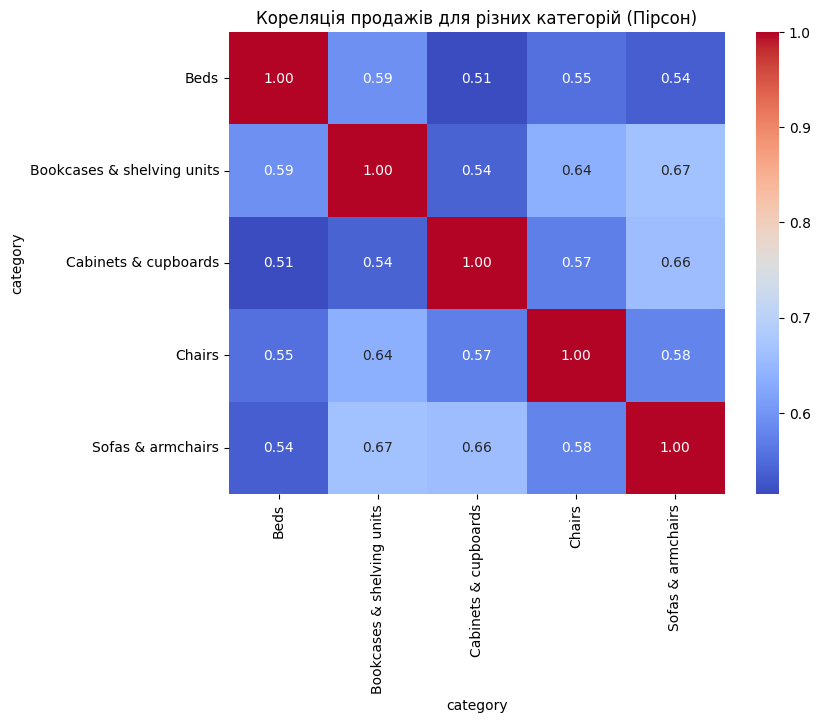

In [146]:
# Візуалізація кореляцій heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Кореляція продажів для різних категорій (Пірсон)")
plt.show()

**Висновок щодо кореляції продажів між категоріями:** Категорії меблів для зберігання (Bookcases & Shelving Units, Cabinets & Cupboards) мають сильний взаємозв’язок із сидячими меблями (Sofas & Armchairs, Chairs), а категорія Beds демонструє слабший, але стабільний зв’язок із більшістю інших товарів.

*Кореляція Пірсона показує:*
- Найвища кореляція: найбільш пов’язаними категоріями є Sofas & Armchairs та Bookcases & Shelving Units (0.67), а також Sofas & Armchairs та Cabinets & Cupboards (0.66), що може свідчити про схожий попит або часте спільне придбання. Високу кореляцію також мають Chairs та Bookcases & Shelving Units (0.64).
- Помірна кореляція: Помірну кореляцію спостерігаємо між Bookcases & Shelving Units та Beds (0.59), Sofas & Armchairs та Chairs (0.58), Chairs та Beds (0.55), Sofas & Armchairs та Beds (0.54).
- Найнижча кореляція серед значущих: Найнижчий, але все ще значущий зв’язок зафіксовано між Beds та Cabinets & Cupboards (0.51).

*Кореляція Спірмена підтверджує подібні тенденції:*
- Найвища кореляція: Bookcases & Shelving Units та Chairs (0.64), Bookcases & Shelving Units та Sofa Arm Chairs (0.63), Cabinets & Cupboards та Sofas & Armchairs (0.63) мають найсильніший зв’язок.
- Помірна кореляція: Помірна кореляція відзначена між Sofas & Armchairs та Chairs (0.58), Bookcases & Shelving Units та Beds (0.54), Beds та Chairs (0.53), Cabinets & Cupboards та Chairs (0.53), Beds та Sofas & Armchairs (0.52).
- Найнижча кореляція серед значущих: Найнижча, але значуща кореляція — Beds та Cabinets & Cupboards (0.44).

Значення p-value для обох коефіцієнтів дуже низькі, що свідчить про високу статистичну значущість виявлених взаємозв’язків.

# Статистичний аналіз відмінностей між групами

### Аналіз продажів за кожну дату зареєстрованих та незареєстрованих користувачів

In [147]:
# Додаємо новий стовпець "account_status"
df['account_status'] = np.where(df['user_id'] != 0, 'registered', 'unregistered')
account_grouped_by_date = df.groupby(["date", "account_status"])["price"].sum().reset_index()
account_grouped_df = df.groupby(["date", "account_status"])["price"].sum().unstack().reset_index()
# Перейменовуємо стовпці
account_grouped_df.columns = ["date", "registered_group", "unregistered_group"]
print(account_grouped_df)

         date  registered_group  unregistered_group
0  2020-11-01           21547.0            222745.5
1  2020-11-02           44956.8            310550.0
2  2020-11-03           29150.5            469829.1
3  2020-11-04           20982.2            318204.9
4  2020-11-05           25334.6            365942.0
..        ...               ...                 ...
87 2021-01-27           14613.6            271727.1
88 2021-01-28               NaN                 0.0
89 2021-01-29               NaN                 0.0
90 2021-01-30               NaN                 0.0
91 2021-01-31               NaN                 0.0

[92 rows x 3 columns]


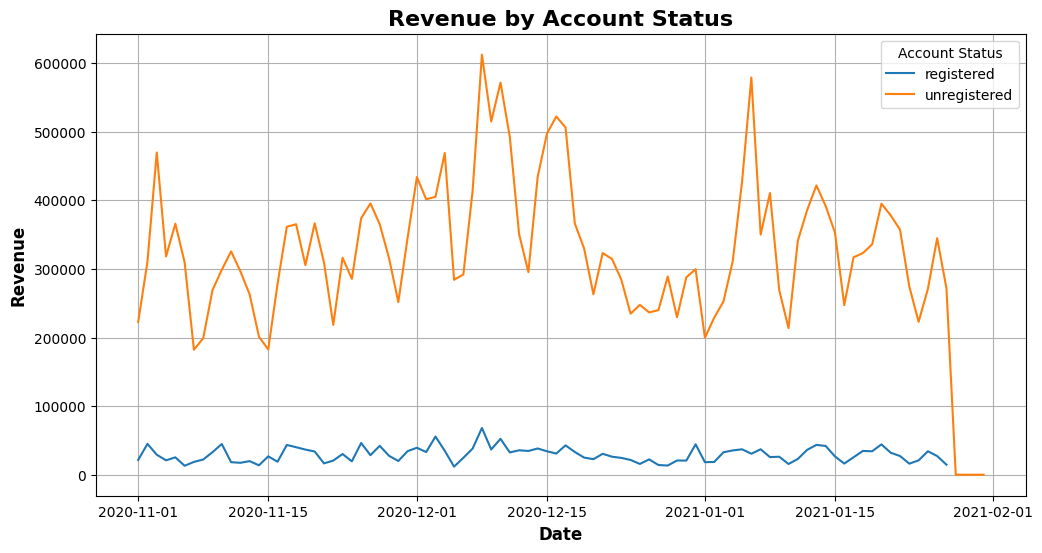

In [148]:
# Створення візуалізації
plt.figure(figsize=(12, 6))
sns.lineplot(data=account_grouped_by_date, x="date", y="price", hue="account_status")
plt.title("Revenue by Account Status", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12, fontweight="bold")
plt.ylabel("Revenue", fontsize=12, fontweight="bold")
plt.legend(title="Account Status")
plt.grid()
plt.show()

In [149]:
# Створення вибірок
registered_sales = account_grouped_df["registered_group"].dropna()
unregistered_sales = account_grouped_df["unregistered_group"].dropna()

Normaltest for Registered group p-value: 0.010929121653065912
Normaltest for Unregistered group p-value: 0.026362411185738954
-----------------------------------------------------------------
Shapiro-Wilk for Registered group p-value: 0.007295139880540744
Shapiro-Wilk for Unregistered group p-value: 0.0012184604855253293


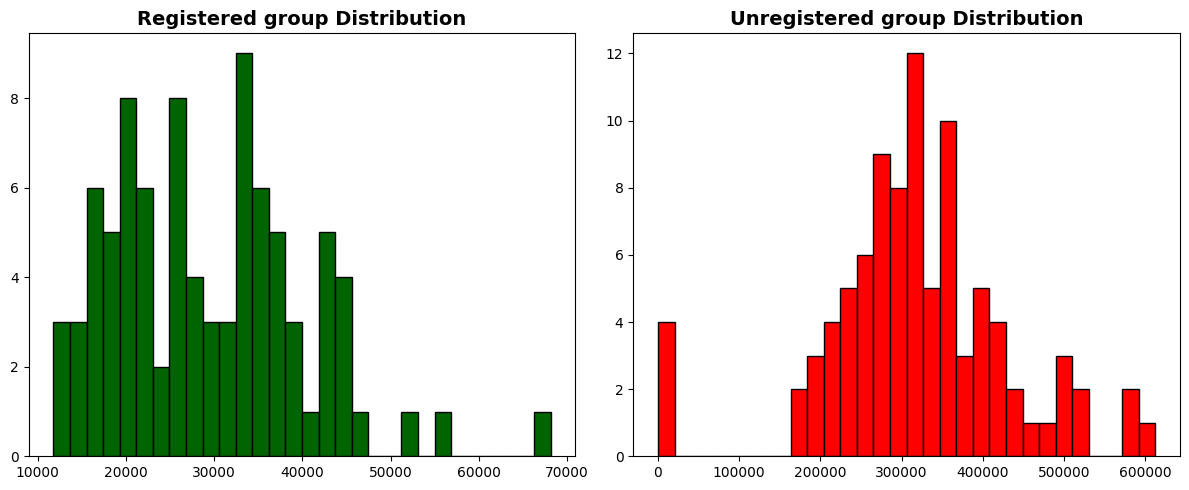

In [150]:
# Аналіз нормальності розподілу даних
# Normaltest
_, p_value_normaltest_registered_group = normaltest(registered_sales)
_, p_value_normaltest_unregistered_group = normaltest(unregistered_sales)
# Shapiro-Wilk test
_, p_value_shapiro_registered_group = shapiro(registered_sales)
_, p_value_shapiro_unregistered_group = shapiro(unregistered_sales)
# Test results
print(f"Normaltest for Registered group p-value: {p_value_normaltest_registered_group}")
print(f"Normaltest for Unregistered group p-value: {p_value_normaltest_unregistered_group}")
print("-"*65)
print(f"Shapiro-Wilk for Registered group p-value: {p_value_shapiro_registered_group}")
print(f"Shapiro-Wilk for Unregistered group p-value: {p_value_shapiro_unregistered_group}")
# Plotting histograms to visualize data distributions
plt.figure(figsize=(12, 5))
# Registered group distribution
plt.subplot(1, 2, 1)
plt.hist(account_grouped_df['registered_group'], bins=30, color="darkgreen", edgecolor="black")
plt.title("Registered group Distribution", fontsize=14, fontweight = "bold")
# Unregistered group distribution
plt.subplot(1, 2, 2)
plt.hist(account_grouped_df['unregistered_group'], bins=30, color="red", edgecolor="black")
plt.title("Unregistered group Distribution", fontsize=14, fontweight = "bold")
plt.tight_layout()
plt.show()

**Висновок:**
Розподіли для Registered group і Unregistered group не відповідають нормальному розподілу на основі результатів обох тестів (p-value < 0.05).
Оскільки розподіли змінних в групах не є нормальними, Тест Манна-Вітні (Mann-Whitney U test) є більш підходящим вибором так, як використовується для порівняння двох незалежних вибірок, коли дані не підкоряються нормальному розподілу. Він дозволяє перевірити, чи є статистично значущою різниця двох груп.



In [151]:
u_stat, p_value = mannwhitneyu(registered_sales, unregistered_sales, alternative="two-sided")
print(f"Mann-Whitney U test: p-value = {p_value}")

Mann-Whitney U test: p-value = 3.8805185465235906e-26


**Висновок:**
Оскільки p-value < 0.05, це свідчить про статистично значущу різницю між продажами для зареєстрованих і незареєстрованих користувачів.

### Аналіз кількості сесій за різними каналами трафіку

In [152]:
# Групування за датою та каналами (враховуємо всі сесії, а не лише ті, де були замовлення)
channel_df = df.groupby(["date", "channel"])["ga_session_id"].count().unstack().reset_index()
print(channel_df)

channel       date  Direct  Organic Search  Paid Search  Social Search  Undefined
0       2020-11-01     608             920          706            214        128
1       2020-11-02     810            1242          970            315        262
2       2020-11-03    1216            1871         1367            392        327
3       2020-11-04     935            1425         1145            368        311
4       2020-11-05     845            1293          917            346        342
..             ...     ...             ...          ...            ...        ...
87      2021-01-27     984            1561         1192            359        339
88      2021-01-28     997            1379         1107            364        265
89      2021-01-29     878            1319          988            288        227
90      2021-01-30     685             989          787            218        166
91      2021-01-31     644            1051          729            228        160

[92 rows x 6 co

In [153]:
# Створення вибірок
di_channel = channel_df["Direct"].dropna()
os_channel= channel_df["Organic Search"].dropna()
ps_channel= channel_df["Paid Search"].dropna()
ss_channel= channel_df["Social Search"].dropna()
un_channel= channel_df["Undefined"].dropna()

In [154]:
# Використання тесту Крускала-Уолліса (Kruskal-Wallis test) для порівняння більше ніж двох вибірок
stat, p_value = kruskal(di_channel, os_channel, ps_channel, ss_channel, un_channel)
print(f"Kruskal-Wallis statistic: {stat}")
print(f"P-value: {p_value}")
# Інтерпретація результатів
if p_value < 0.05:
    print("Різниця між кількістю сесій за різними каналами трафіку статистично значуща.")
else:
    print("Немає статистично значущої різниці між кількістю сесій за різними каналами трафіку.")

Kruskal-Wallis statistic: 368.98057369864847
P-value: 1.397036102599359e-78
Різниця між кількістю сесій за різними каналами трафіку статистично значуща.


### Аналіз долі сесій з органічним трафіком у Європі та Америці

In [155]:
# Фільтрація даних для континентів (враховуємо всі сесії, а не лише ті, де були замовлення)
df_filtered = df[df["continent"].isin(["Americas", "Europe"])]
grouped_df = filtered_df.groupby(["channel", "continent"])["ga_session_id"].count().reset_index()
print(grouped_df)

           channel continent  ga_session_id
0           Direct  Americas           3911
1           Direct      Asia            728
2           Direct    Europe            375
3   Organic Search  Americas           5888
4   Organic Search      Asia           1054
5   Organic Search    Europe            611
6      Paid Search  Americas           4523
7      Paid Search      Asia            763
8      Paid Search    Europe            460
9    Social Search  Americas           1362
10   Social Search      Asia            227
11   Social Search    Europe            115
12       Undefined  Americas           1031
13       Undefined      Asia            171
14       Undefined    Europe             88


In [156]:
# Підрахунок загальної кількості сесій та органічних сесій
df_counts = df_filtered.pivot_table(
    index="continent", columns="channel", values="ga_session_id", aggfunc="count"
).fillna(0)
# Витягуємо потрібні значення
n1, n2 = df_counts.sum(axis=1)  # Загальна кількість сесій у Європі та Америці
x1, x2 = df_counts["Organic Search"]  # Кількість органічних сесій
# Виконуємо Z-тест для отриманих результатів
z_stat, p_value = sm.stats.proportions_ztest([x1, x2], [n1, n2])
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")
# Інтерпретація результатів
if p_value < 0.05:
    print("Різниця між долею сесій з органічним трафіком у Європі та Америці статистично значуща.")
else:
    print("Немає статистично значущої різниці між долею сесій з органічним трафіком у Європі та Америці.")

Z-statistic: -0.28951412926103953
P-value: 0.7721879690501752
Немає статистично значущої різниці між долею сесій з органічним трафіком у Європі та Америці.


In [157]:
# Альтернативний варіант розрахунку долі сесій з органічним трафіком у Європі та Америці
session_eu = df[df["continent"]=="Europe"]["ga_session_id"].count() # Загальна кількість сесій у Європі
session_am = df[df["continent"]=="Americas"]["ga_session_id"].count() # Загальна кількість сесій у Америці
session_eu_os = df[(df["continent"]=="Europe") & (df["channel"] == "Organic Search")]["ga_session_id"].count() # Кількість органічних сесій у Європі
session_am_os = df[(df["continent"]=="Americas") & (df["channel"] == "Organic Search")]["ga_session_id"].count() # Кількість органічних сесій у Америці
# Виконуємо Z-тест
z_stat, p_value = sm.stats.proportions_ztest([session_eu_os, session_am_os], [session_eu, session_am])
print(f"Z-statistic: {z_stat}")
print(f"P-value: {p_value}")
# Інтерпретація результатів
if p_value < 0.05:
    print("Різниця між долею сесій з органічним трафіком у Європі та Америці статистично значуща.")
else:
    print("Немає статистично значущої різниці між долею сесій з органічним трафіком у Європі та Америці.")

Z-statistic: 0.28951412926103953
P-value: 0.7721879690501752
Немає статистично значущої різниці між долею сесій з органічним трафіком у Європі та Америці.


# Посилання на аналітичний дашборд у Tableau Public



https://public.tableau.com/views/Salesdistribution_17401411730140/Salesdistribution?:language=en-GB&publish=yes&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link